# Requaired Libraries 

In [532]:
import re
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 

from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report
from xgboost import XGBClassifier

# Load Dataset

In [498]:
df=pd.read_csv('train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Dataset Shape

In [549]:
print("Rows :", df.shape[0])
print("Columns :",df.shape[1])

Rows : 891
Columns : 13


# Info 

In [500]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [501]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


# Missing Values

In [502]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

# Features 

In [503]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


# Feature Engineering 

In [504]:
df['Title']=df['Name'].apply(lambda x: re.search(' ([A-Za-z]+)\.',x).group(1))

<>:1: SyntaxWarning: invalid escape sequence '\.'
<>:1: SyntaxWarning: invalid escape sequence '\.'
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_10316\251810764.py:1: SyntaxWarning: invalid escape sequence '\.'
  df['Title']=df['Name'].apply(lambda x: re.search(' ([A-Za-z]+)\.',x).group(1))


In [505]:
rar_t=['Dr','Rev','Major','Col','Capt','Lady','Countess','Sir','Don','Jonkheer']

df['Title']=df['Title'].replace(rar_t, 'Rare')
df['Title']=df['Title'].replace(['Ms','Mlle'], 'Miss')
df['Title']=df['Title'].replace('Mme', 'Mrs')
df['Title'].value_counts()


Title
Mr        517
Miss      185
Mrs       126
Master     40
Rare       23
Name: count, dtype: int64

# Features

In [506]:
X= df[['Sex','Title','Parch','SibSp', "Age", 'Fare', 'Embarked', 'Pclass']]
y=df['Survived']

In [507]:
cat_col= ['Sex','Embarked','Title']
num_col= ['Age', 'Fare','Pclass','SibSp','Parch']

# Column Transformer

In [508]:
preprocessor=ColumnTransformer([
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ]), cat_col),
    
    ('num', Pipeline([
        ('imputer',SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), num_col)
])

# PipeLine

In [543]:
pipe= Pipeline([
    ('preprocessor', preprocessor),
    ('model',RandomForestClassifier(n_estimators=300, max_depth=5,
                                    random_state=42,class_weight='balanced',
                                    min_samples_leaf=2,min_samples_split=5,
                                    max_features="sqrt",bootstrap=True ))
])

# Spliting Data

In [544]:
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.2,
                                                  random_state=42)

# Fit And Prediction 

In [545]:
pipe.fit(X_train, y_train)
y_pred=pipe.predict(X_test)

# Accuracy 

In [546]:
print('Accuracy :', accuracy_score(y_test, y_pred))

Accuracy : 0.8212290502793296


# Classification Report 

In [547]:
print('Classification Report :')
print(classification_report(y_test, y_pred))

Classification Report :
              precision    recall  f1-score   support

           0       0.84      0.86      0.85       105
           1       0.79      0.77      0.78        74

    accuracy                           0.82       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179



# Confusion Matrix 

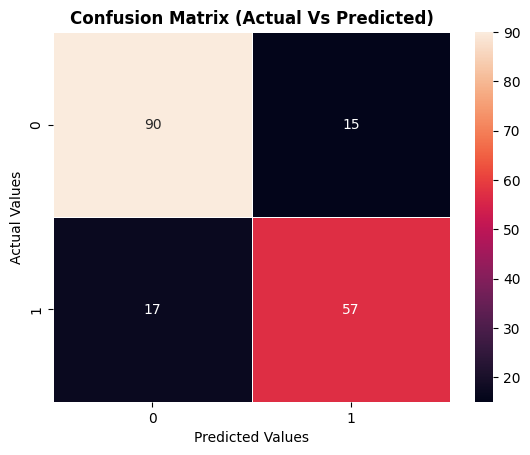

In [548]:
cm=confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', linewidth=0.5)
plt.title('Confusion Matrix (Actual Vs Predicted)', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()